Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

First, L2 regularization for *logistic regression* model.

The multinomial logistic regression model with stochastic gradient descent is adapted from assignment 2:2_fullyconnected.ipynb


In [37]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    '''
    Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch.  
    '''
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)  # Learning rate for regularization
    
    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + 
                          beta * tf.nn.l2_loss(weights))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [38]:
num_steps = 3000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps+1):
        '''
        Pick an offset within the training data, which has been randomized.
        Note: we could use better randomization across epochs.
        '''
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        '''
        Prepare a dictionary telling the session where to feed the minibatch.
        The key of the dictionary is the placeholder node of the graph to be fed,
        and the value is the numpy array to feed to it.
        '''
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta: 0.01}  # Use 0.01 for beta
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 46.824379
Minibatch accuracy: 8.6%
Validation accuracy: 12.8%
Minibatch loss at step 500: 0.733136
Minibatch accuracy: 87.5%
Validation accuracy: 81.2%
Minibatch loss at step 1000: 0.800147
Minibatch accuracy: 80.5%
Validation accuracy: 81.3%
Minibatch loss at step 1500: 0.566087
Minibatch accuracy: 83.6%
Validation accuracy: 81.1%
Minibatch loss at step 2000: 0.648335
Minibatch accuracy: 88.3%
Validation accuracy: 81.2%
Minibatch loss at step 2500: 0.782492
Minibatch accuracy: 78.9%
Validation accuracy: 81.1%
Minibatch loss at step 3000: 0.784389
Minibatch accuracy: 80.5%
Validation accuracy: 81.4%
Test accuracy: 88.6%


Recall from assignment 2 that the final result without regularization is:

###### Minibatch loss at step 3000: *1.061334*
###### Minibatch accuracy: *77.3%*
###### Validation accuracy: *79.0%*
###### Test accuracy: *86.4%*

Now let's try different values for beta:

In [46]:
num_steps = 3000
beta_values = [pow(10, i) for i in np.arange(-4, -1, 0.1)] # from 0.0001 to 0.1
results = np.zeros(len(beta_values))

for i, beta_value in enumerate(beta_values):
    
    with tf.Session(graph=graph) as session:
        
        tf.initialize_all_variables().run()        
        for step in range(num_steps+1):
            
            '''
            Pick an offset within the training data, which has been randomized.
            Note: we could use better randomization across epoch
            '''
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            '''
            Prepare a dictionary telling the session where to feed the minibatch.
            The key of the dictionary is the placeholder node of the graph to be fed,
            and the value is the numpy array to feed to it.
            '''
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : beta_value}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            
        results[i] = accuracy(test_prediction.eval(), test_labels)
        # Print the progress
        if(i%5 == 0):
            print('%0.1f%% finished' %(100*i/len(beta_values)))
            
print('Done!')

0.0% finished
16.0% finished
33.0% finished
50.0% finished
66.0% finished
83.0% finished
Done!


Let's plot the result:

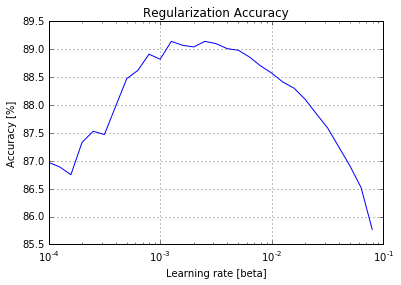

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogx(beta_values, results)
plt.xlabel('Learning rate [beta]')
plt.ylabel('Accuracy [%]')
plt.grid(True)
plt.title('Regularization Accuracy')
plt.show()


Second, L2 regularization for *neural network* model.

In [36]:
batch_size = 128
hidden_nodes_size = 1024   # This is the number of the nodes in the hidden layer
betha = 0.01  # Learning rate for regularization

graph = tf.Graph()
with graph.as_default():
    '''
    Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch.  
    '''
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes_size]))
    biases1 = tf.Variable(tf.zeros([hidden_nodes_size]))
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes_size, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits = tf.matmul(tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1), weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + 
                          betha * tf.nn.l2_loss(weights1) + 
                          betha * tf.nn.l2_loss(weights2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden, weights2) + biases2)
    
    test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(test_hidden, weights2) + biases2)

Let's run it:

In [26]:
num_steps = 3000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps+1):
        '''
        Pick an offset within the training data, which has been randomized.
        Note: we could use better randomization across epochs.
        '''
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        '''
        Prepare a dictionary telling the session where to feed the minibatch.
        The key of the dictionary is the placeholder node of the graph to be fed,
        and the value is the numpy array to feed to it.
        '''
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3472.870850
Minibatch accuracy: 8.6%
Validation accuracy: 29.2%
Minibatch loss at step 500: 21.234951
Minibatch accuracy: 86.7%
Validation accuracy: 84.3%
Minibatch loss at step 1000: 0.948464
Minibatch accuracy: 81.2%
Validation accuracy: 83.3%
Minibatch loss at step 1500: 0.581729
Minibatch accuracy: 87.5%
Validation accuracy: 83.4%
Minibatch loss at step 2000: 0.606362
Minibatch accuracy: 91.4%
Validation accuracy: 83.4%
Minibatch loss at step 2500: 0.714091
Minibatch accuracy: 82.8%
Validation accuracy: 83.2%
Minibatch loss at step 3000: 0.763866
Minibatch accuracy: 83.6%
Validation accuracy: 83.5%
Test accuracy: 90.4%


Recall from assignment 2 that the final result without regularization is:

###### Minibatch loss at step 3000: *1.388752*
###### Minibatch accuracy: *82.0%*
###### Validation accuracy: *81.7%*
###### Test accuracy: *88.8%*

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Initialized
Minibatch loss at step 0: 3517.083496
Minibatch accuracy: 10.2%
Validation accuracy: 26.5%
Test accuracy: 81.9%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
